# Analyze classifier evidence based on context decoding

In [1]:
import os
from pathlib import Path
import pingouin as pg

from dcmr import task
from dcmr import decode
from dcmr import figures

cfr_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])

model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1'
sublayer = 'use'
class_dir = fit_dir / model_name / f'decode_{sublayer}' / 'logreg_pmvpa_r10'
kind = 'context'
kind_label = 'Context'

fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim3'
fig_dir.mkdir(exist_ok=True)
figures.set_style()

## Read classifier evidence

In [2]:
subjects, _ = task.get_subjects()
evidence = decode.read_evidence(class_dir, subjects)
evidence = evidence.query('include')

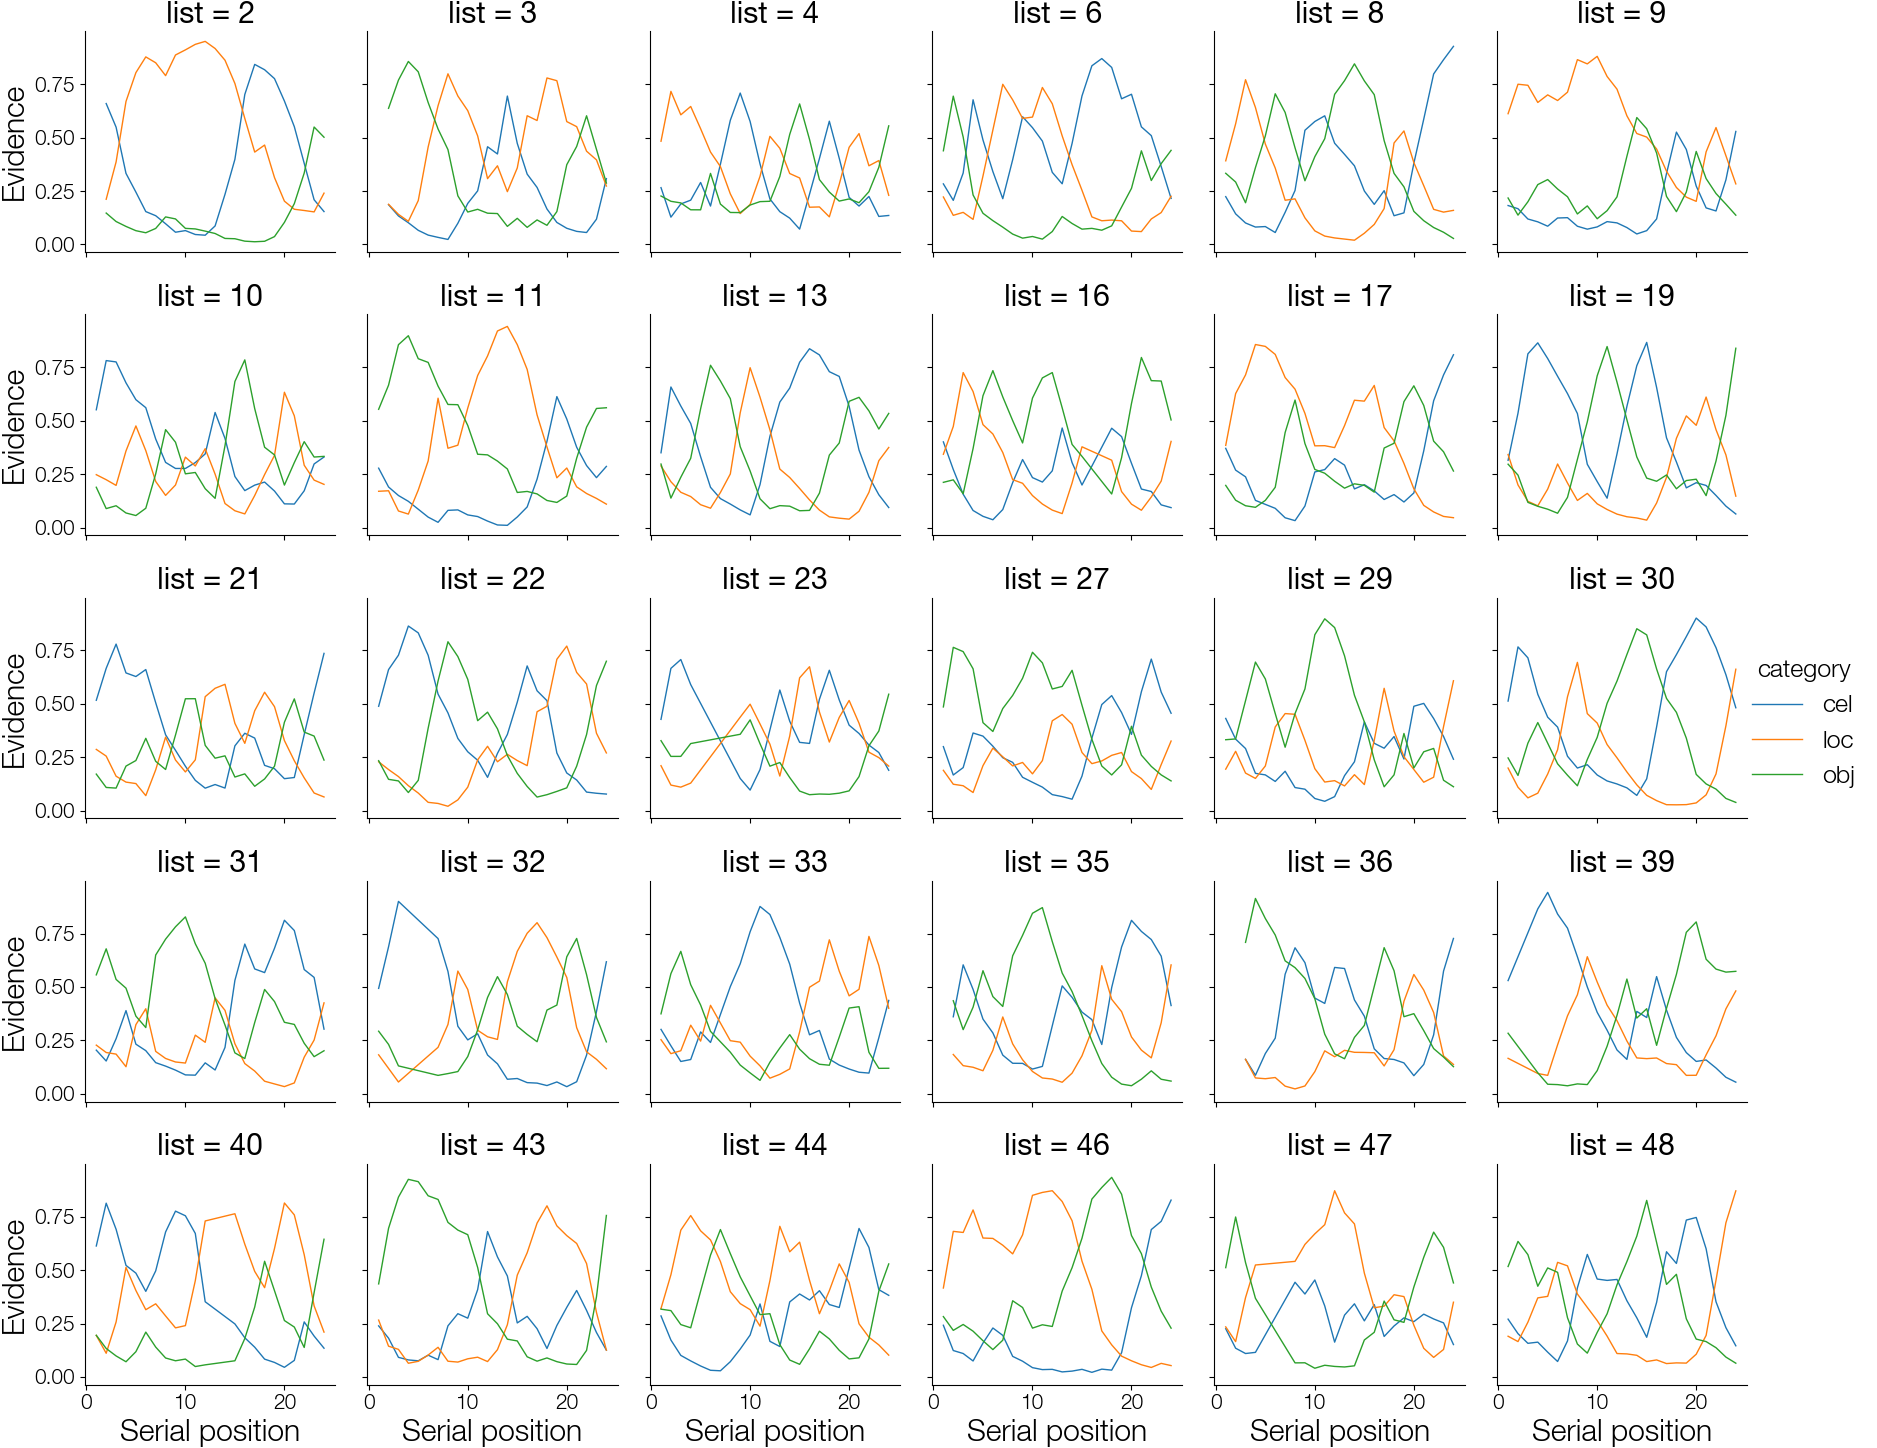

In [3]:
g = figures.plot_trial_evidence(evidence, 1)

## Classifier evidence by block position

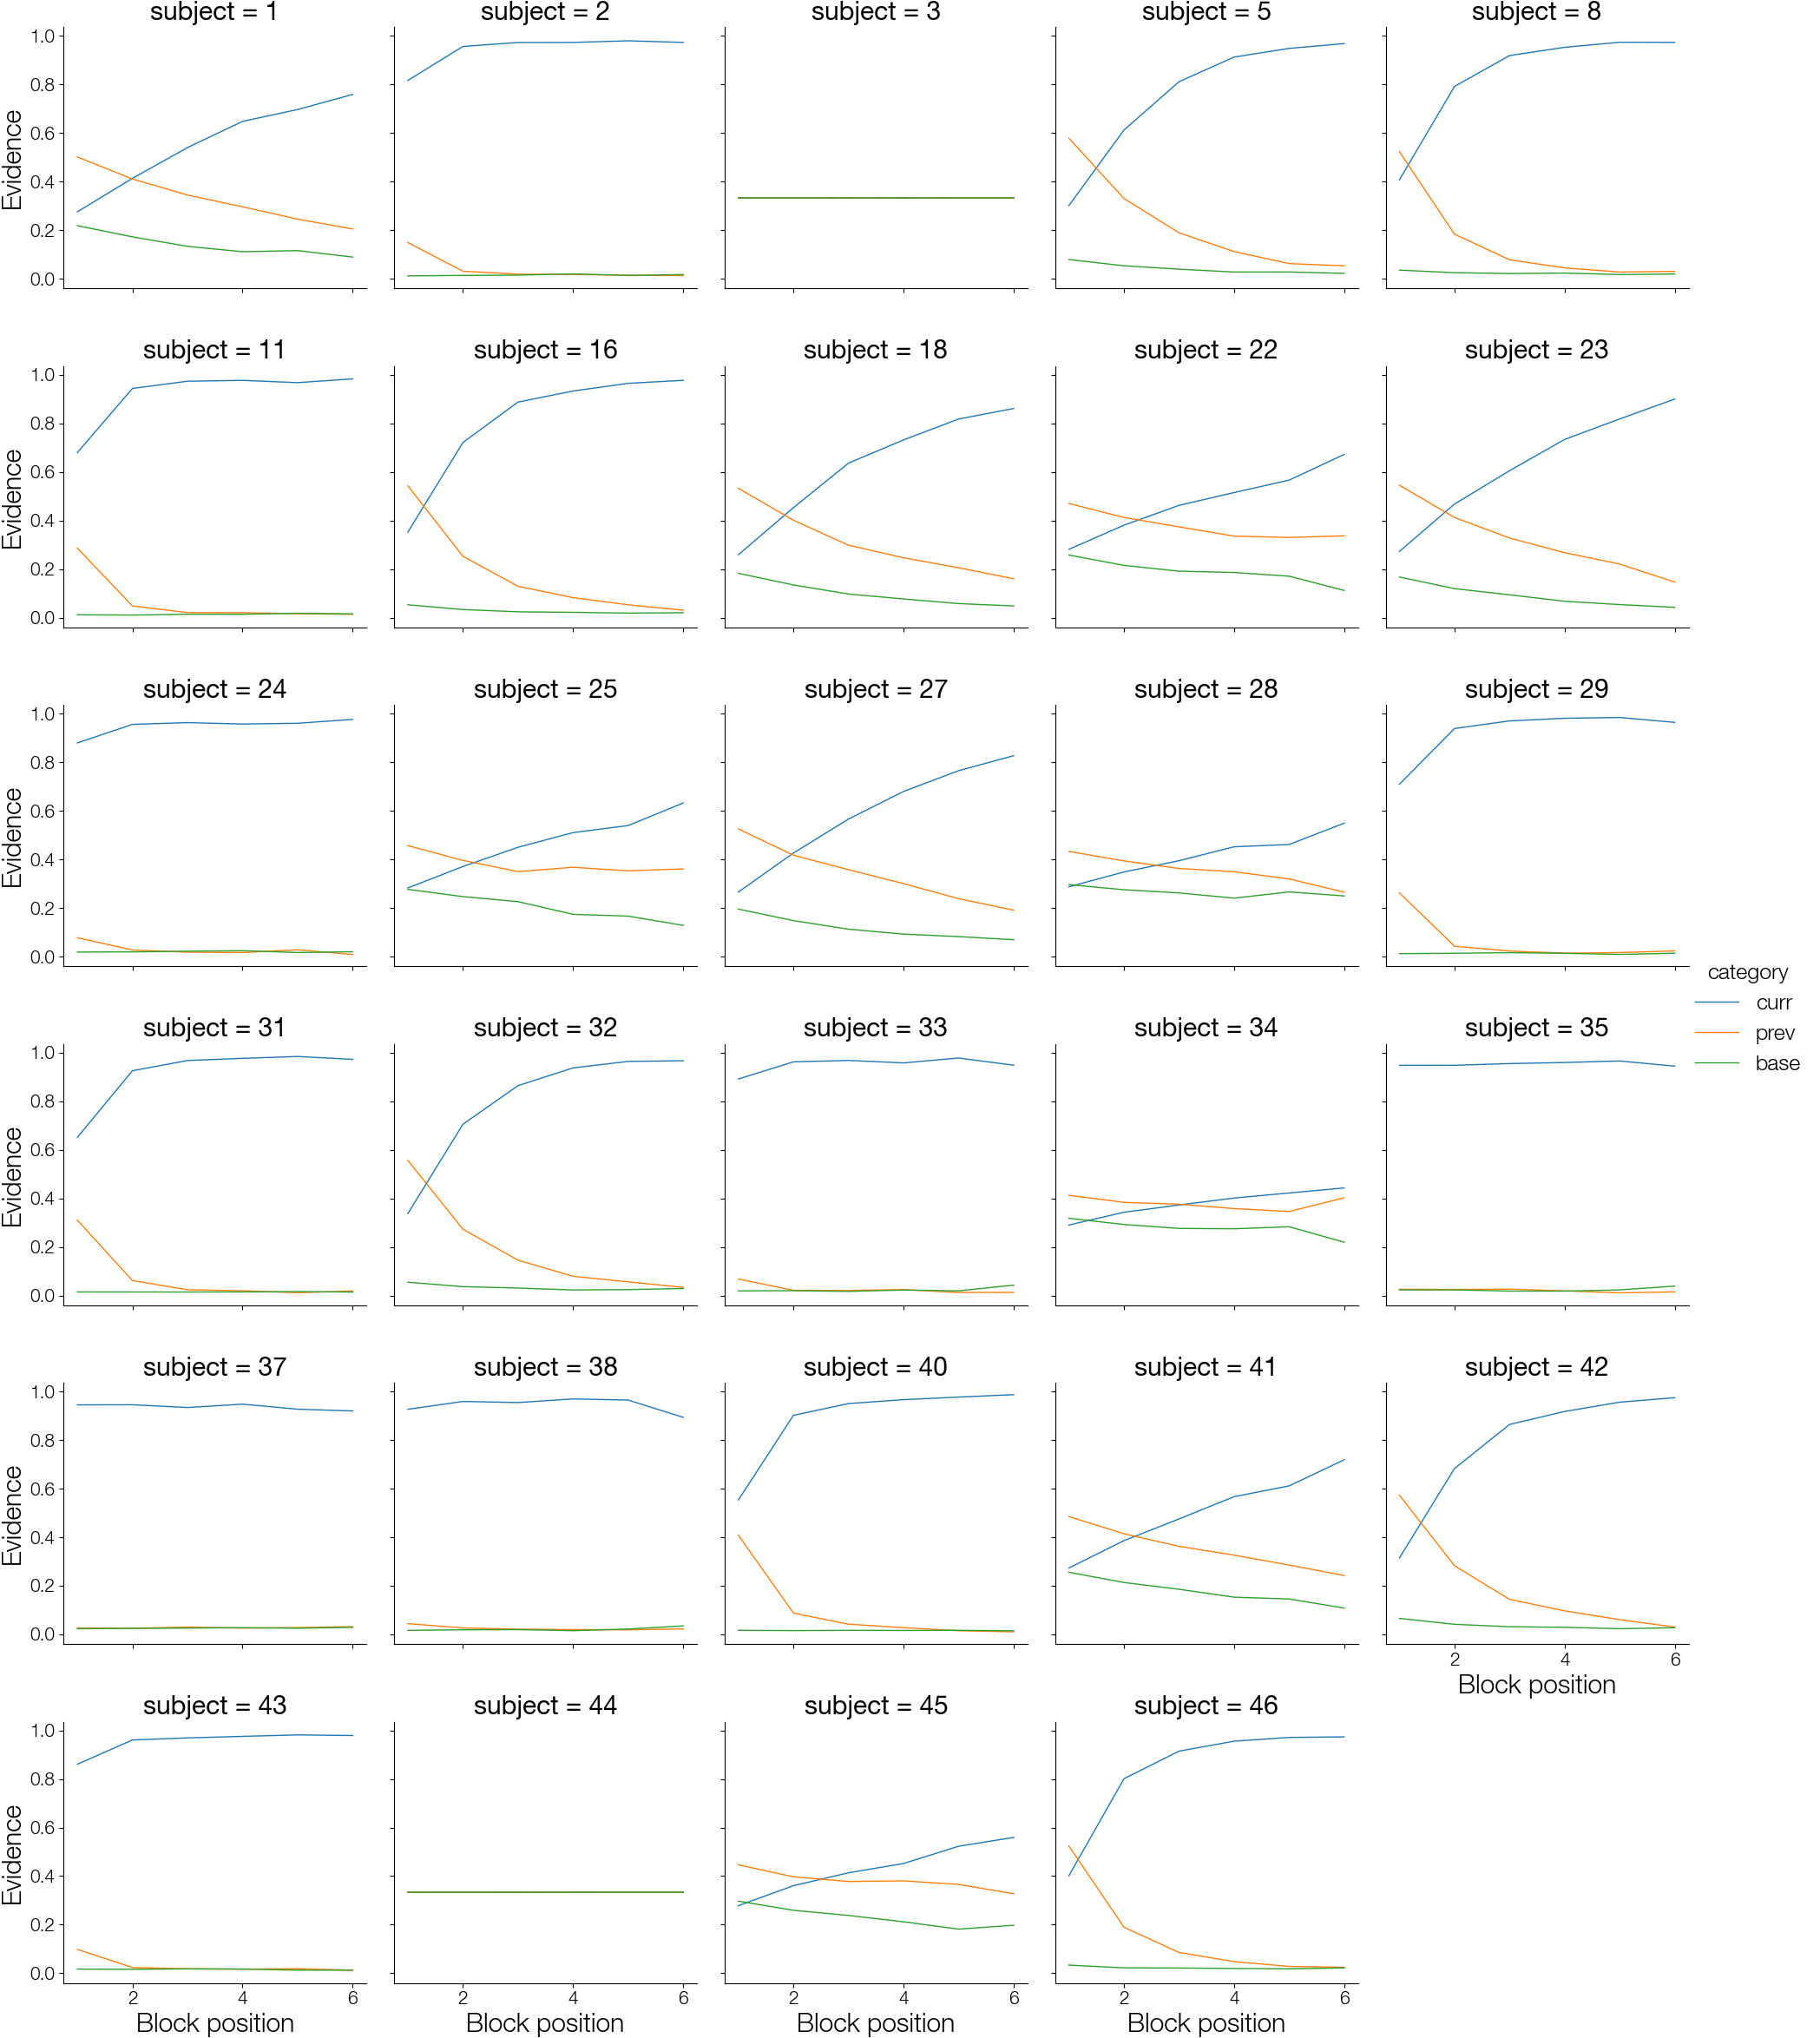

In [4]:
m = decode.evidence_block_pos(evidence)
g = figures.plot_block_pos_evidence(m)

LINO NOT subset; don't know how to subset; dropped


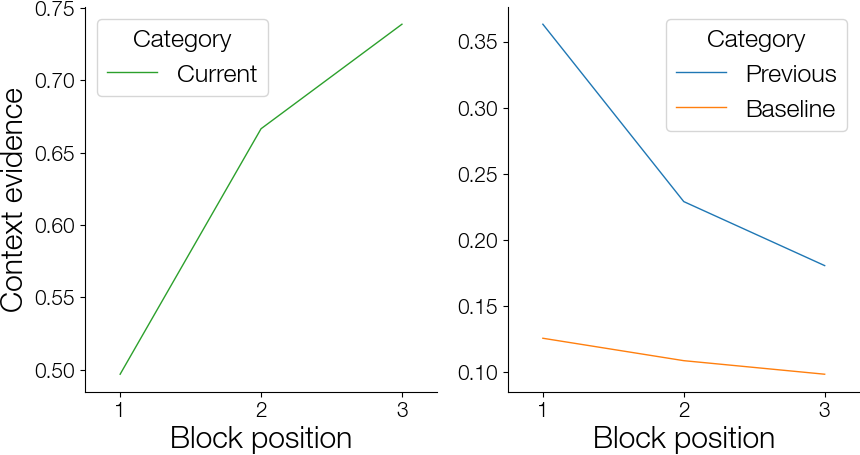

In [5]:
fig, ax = figures.plot_mean_block_pos_evidence(m)
ax[0].set(ylabel=f'{kind_label} evidence')
fig.savefig(fig_dir / f'evidence_block_{kind}.pdf')

## Slope over block position

/Users/nmorton/VSCode/dcmr/src/dcmr/figures.py:416: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  )
LINO NOT subset; don't know how to subset; dropped


,curr,prev,base
mean,0.125313,-0.095156,-0.013907
sem,0.017893,0.015021,0.002984


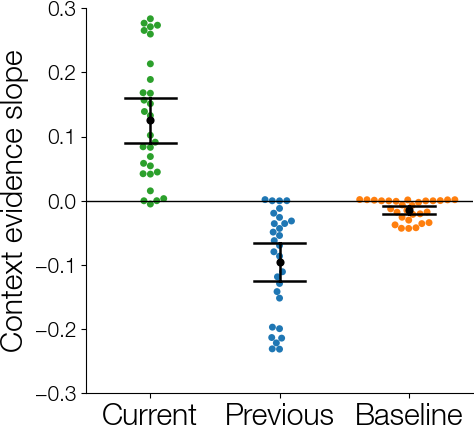

In [12]:
slope = decode.regress_evidence_block_pos(m)
fig, ax = figures.plot_slope_evidence(slope)
ax.set(ylim=(-0.3, 0.3), ylabel=f'{kind_label} evidence slope')
fig.savefig(fig_dir / f'evidence_slope_{kind}.pdf')
slope.agg(['mean', 'sem'])

In [7]:
pg.ttest(slope['curr'], 0, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.003526,28,greater,6.442273e-08,"[0.09, inf]",1.300522,2.374e+05,1.0


In [8]:
pg.ttest(slope['prev'], 0, alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.334745,28,less,3.735516e-07,"[-inf, -0.07]",1.176333,4.635e+04,0.999997


In [9]:
pg.ttest(slope['base'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.6601,28,two-sided,0.00007,"[-0.02, -0.01]",0.865359,359.687,0.99438


In [17]:
slope.to_csv(class_dir / "slope.csv")

In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 9.2.0

dcmr    : 1.0.0a0
pingouin: 0.5.5

